<h1>Data Challenge 1 - Matt Cook - 10/12/18<h1>

<h1>Intro</h1>
<b>Problem: Using breast cancer data from the University of Wisconsin, predict if a biopsied breast tissue section is benign or malignant</b>
<p>This problem is a supervised classification problem. Each tissue section has an ID number, is classified as benign or malignant, and contains a set of features describing the attributes present in each tissue section: 1. clump thickness, 2. cell size uniformity, 3. cell shape uniformity, 4. marginal adhesion, 5. single epithelial cell size, 6. bare nuclei, 7. bland chromatin, 8. normal nucleoli, or 9. mitosis. Given a particular set of features, the classfication algorithm will predict if a biopsied tissue section is benign or malignant</p>

In [ ]:
import itertools
import numpy as np
from scipy import interp
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.base import clone
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

<h1> 1. Obtain Breast Cancer Data </h1>

In [2]:
# The filename for our data
# Downloaded from: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
# Description of data: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original)

breast_cancer_data_filename = "breast-cancer-wisconsin.csv"

In [3]:
# List of feature names from webpage of data description

feature_names = ["id_number",
                 "clump_thickness",
                 "cell_size_uniformity",
                 "cell_shape_uniformity",
                 "marginal_adhesion",
                 "single_epithelial_cell_size",
                 "bare_nuclei",
                 "bland_chromatin",
                 "normal_nucleoli",
                 "mitoses",
                 "class"]

In [4]:
# Read the downloaded data into a pandas dataframe using the feature names as column names

breast_cancer_data = pd.read_csv(breast_cancer_data_filename, names=feature_names)

<h1> 2. Data Cleaning and Exploration </h1>

In [5]:
# Check if there are any null values in the dataframe

breast_cancer_data.isnull().values.any()

False

In [6]:
# Check the data types of each feature

breast_cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id_number                      699 non-null int64
clump_thickness                699 non-null int64
cell_size_uniformity           699 non-null int64
cell_shape_uniformity          699 non-null int64
marginal_adhesion              699 non-null int64
single_epithelial_cell_size    699 non-null int64
bare_nuclei                    699 non-null object
bland_chromatin                699 non-null int64
normal_nucleoli                699 non-null int64
mitoses                        699 non-null int64
class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


<p>None of the data is null, but the "bare_nuclei" is not an integer, so it must be converted to an integer type.</p>

In [7]:
# Convert bare_nuclei feature from objects to integer

breast_cancer_data["bare_nuclei"] = breast_cancer_data["bare_nuclei"].apply(pd.to_numeric, errors='coerce')

In [8]:
# Check the data types of each feature again

breast_cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id_number                      699 non-null int64
clump_thickness                699 non-null int64
cell_size_uniformity           699 non-null int64
cell_shape_uniformity          699 non-null int64
marginal_adhesion              699 non-null int64
single_epithelial_cell_size    699 non-null int64
bare_nuclei                    683 non-null float64
bland_chromatin                699 non-null int64
normal_nucleoli                699 non-null int64
mitoses                        699 non-null int64
class                          699 non-null int64
dtypes: float64(1), int64(10)
memory usage: 60.1 KB


<p>The bare_nuclei features are now numeric, but some of them are now null, so they must be removed, or a value must be assigned to them. There are only 16 samples without the bare_nuclei value, so here they will just be removed</p>

In [9]:
# There are 16 rows that do not have an enry for bare_nuclei, so remove those rows

breast_cancer_data = breast_cancer_data[np.isfinite(breast_cancer_data['bare_nuclei'])]

In [10]:
# Check the data types of each feature again

breast_cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
id_number                      683 non-null int64
clump_thickness                683 non-null int64
cell_size_uniformity           683 non-null int64
cell_shape_uniformity          683 non-null int64
marginal_adhesion              683 non-null int64
single_epithelial_cell_size    683 non-null int64
bare_nuclei                    683 non-null float64
bland_chromatin                683 non-null int64
normal_nucleoli                683 non-null int64
mitoses                        683 non-null int64
class                          683 non-null int64
dtypes: float64(1), int64(10)
memory usage: 64.0 KB


In [11]:
# Now finally convert bare nuclei to int64

breast_cancer_data["bare_nuclei"] = breast_cancer_data["bare_nuclei"].astype("int64")

In [12]:
# Check the data types of each feature again

breast_cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
id_number                      683 non-null int64
clump_thickness                683 non-null int64
cell_size_uniformity           683 non-null int64
cell_shape_uniformity          683 non-null int64
marginal_adhesion              683 non-null int64
single_epithelial_cell_size    683 non-null int64
bare_nuclei                    683 non-null int64
bland_chromatin                683 non-null int64
normal_nucleoli                683 non-null int64
mitoses                        683 non-null int64
class                          683 non-null int64
dtypes: int64(11)
memory usage: 64.0 KB


Now each of the features are integers

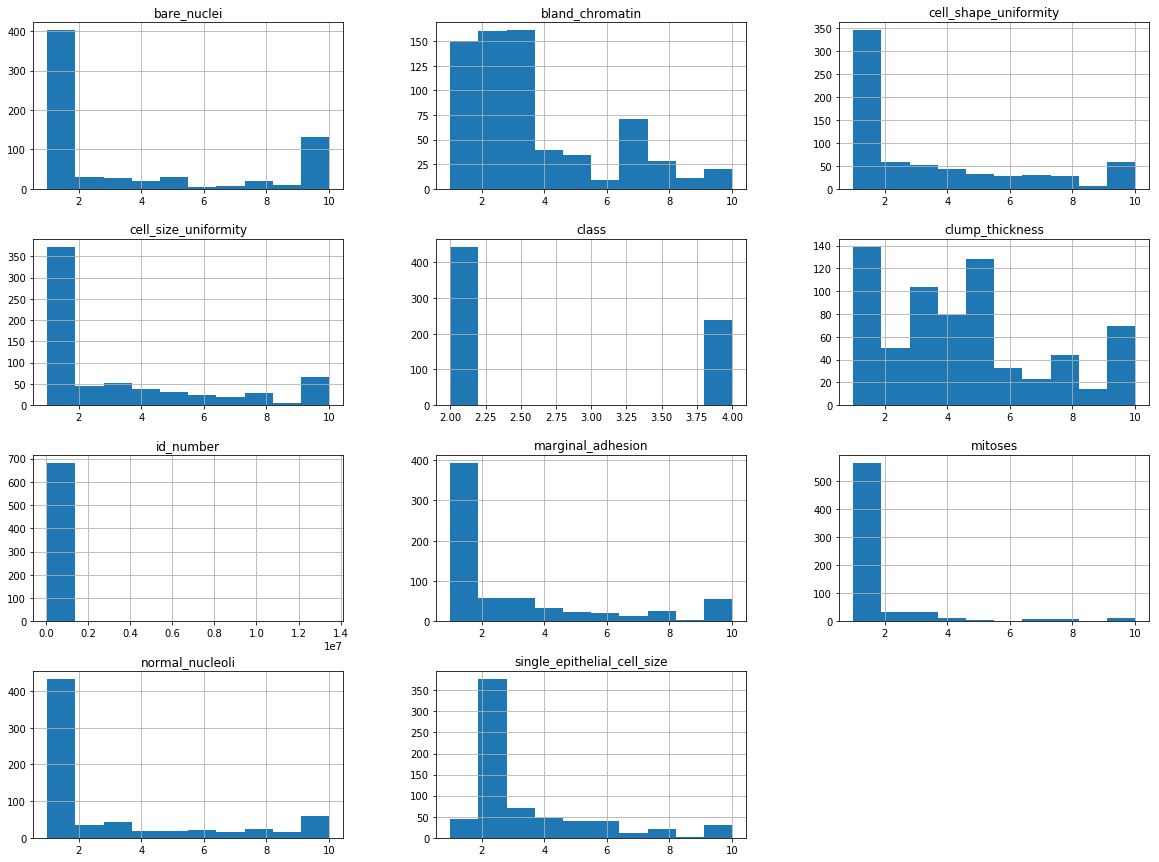

In [13]:
# Check the histograms of data to see what the distribution of each feature is

breast_cancer_data.hist(bins=10, figsize=(20,15))
plt.show()

The classes for benign are labelled as 2 and 4, I will relabel them to 0 and 1

In [14]:
# Change the classes of benign and malignent from 2,4 to 0, 1

cancer_map = {2:0, 4:1}
breast_cancer_data["class"] = breast_cancer_data["class"].map(cancer_map) 

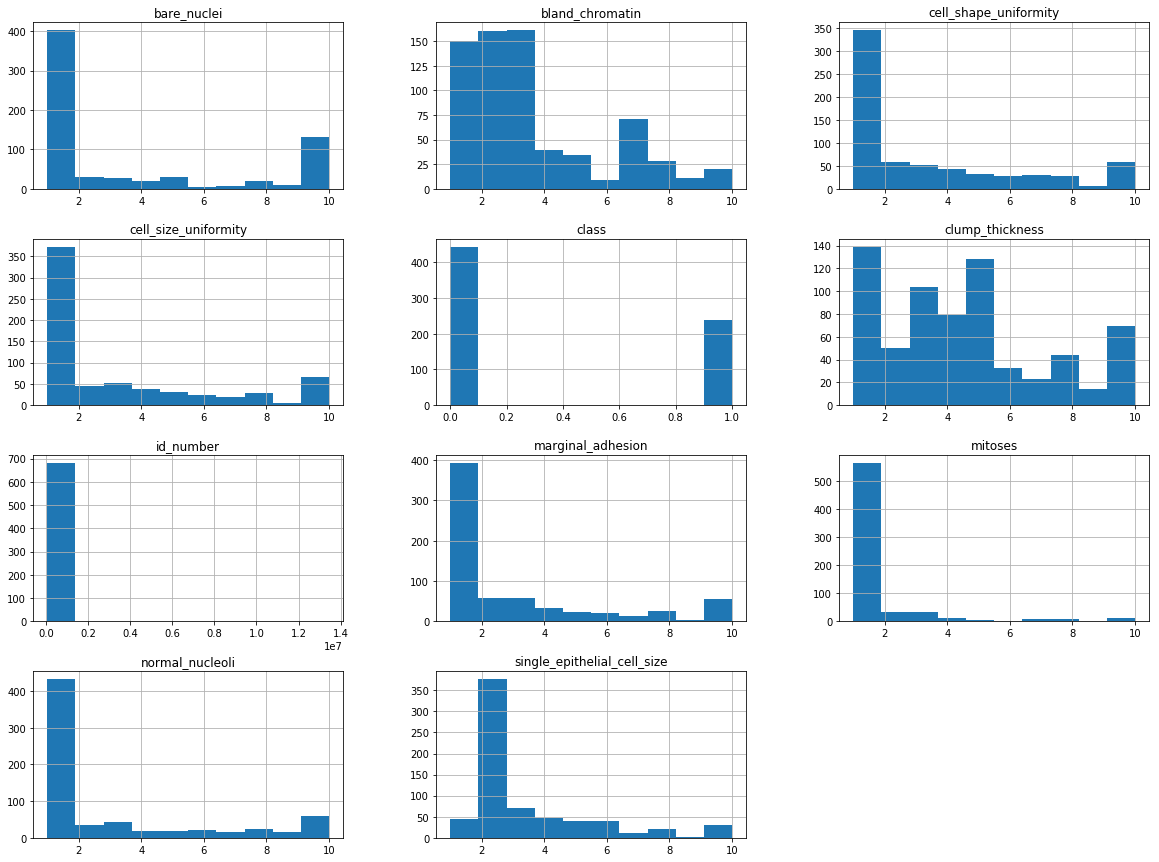

In [15]:
# Check the histograms again to check if the mapping worked

breast_cancer_data.hist(bins=10, figsize=(20,15))
plt.show()

The id number is not an actual feature, so it can be used as the index of the table and dropped from the features table

In [16]:
# id_numbers should not be trained on, so make them the index and drop the columns

breast_cancer_data = breast_cancer_data.set_index("id_number", drop=True)

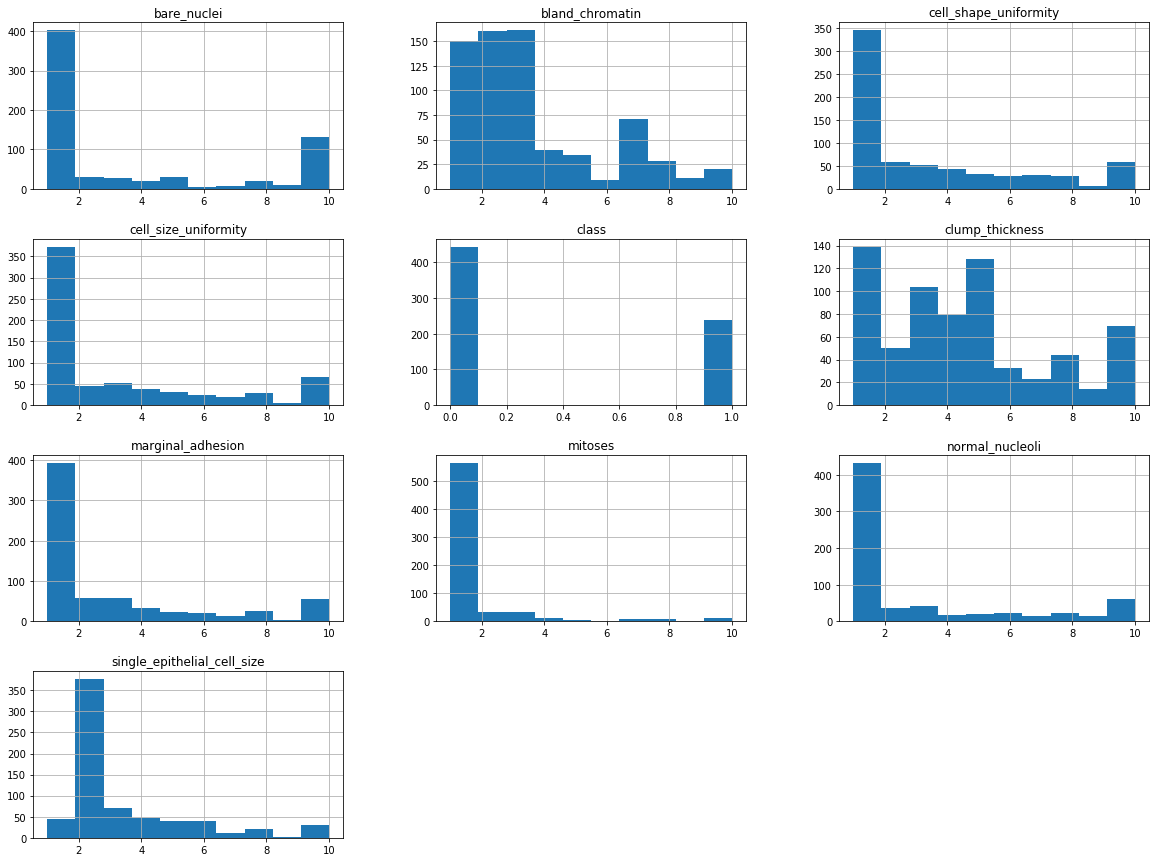

In [17]:
# This is our final data, now for machine learning

breast_cancer_data.hist(bins=10, figsize=(20,15))
plt.show()

Since I will be doing Random Forest Classifer for machine learning, so I will not normalize or transform the feature

<h1>3. Make Train and Test sets for the data and tune parameters for the Random Forest Classifier</h1>

In [57]:
# Make our training and test data for ML algorithms

# Create different dataframes for features and classes
features = breast_cancer_data.iloc[:, breast_cancer_data.columns != "class"]
classes = breast_cancer_data.iloc[:, breast_cancer_data.columns == "class"].values.ravel()

# Make a split train-test split of all of the data
features_train, features_test, classes_train, classes_test = train_test_split(features,
                                                             classes,
                                                             test_size = 0.2,
                                                             random_state = 0,
                                                             shuffle = True,
                                                             stratify = classes)

<b>The Train and Test sets were shuffled and stratified by class so that the same proportion of benign and malignant tumors are in each set
The Test size was 20% of the data</b>

In [58]:
# Set up hypertuning parameters for a Random Forest Classifier with GridSearch

param_grid = [
    {'n_estimators': [500, 1000],
     'max_depth': [3, 6, 9, None],
     'max_features': ["sqrt", "log2", None],
     'criterion': ['gini', 'entropy']}
]

forest_classifier = RandomForestClassifier()

grid_search = GridSearchCV(forest_classifier,
                           param_grid,
                           cv = 5,
                           n_jobs = -1)

<b>The gridsearch was set up for search for the best classifier parameters for n_estimators (number of decision trees in the forest), max_depth (maximum possible depth of each tree in the forest), max_features (number of features to check at each split), and criterion (the scoring function to determine best Out-Of-Bag Score). For each parameter, the score was averaged for 5 cross validations within the training set.</b>

In [59]:
# Fit the Random Forest Classifiers using the GridSearch parameters

grid_search.fit(features_train, classes_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [500, 1000], 'max_depth': [3, 6, 9, None], 'max_features': ['sqrt', 'log2', None], 'criterion': ['gini', 'entropy']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [74]:
# Print the scores for each of the gridsearched estimators

cvres = grid_search.cv_results_
zipped = zip(cvres["mean_test_score"], cvres["params"])
for mean_score, params in zipped:
    print(mean_score, params)

0.9725274725274725 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 500}
0.9725274725274725 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 1000}
0.9725274725274725 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 500}
0.9725274725274725 {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 1000}
0.9652014652014652 {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'n_estimators': 500}
0.9652014652014652 {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'n_estimators': 1000}
0.9761904761904762 {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 500}
0.9761904761904762 {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 1000}
0.978021978021978 {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 500}
0.9798534798534798 {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'n

In [84]:
# Get the best classifier and feature importance scores

best_classifier = grid_search.best_estimator_
feature_importances = best_classifier.feature_importances_
feature_names = features.columns.values

In [85]:
# Display the most important feature scores

sorted(zip(feature_importances, feature_names), reverse=True)

[(0.2941017107642241, 'cell_size_uniformity'),
 (0.22933755330065236, 'cell_shape_uniformity'),
 (0.14609183999913106, 'bare_nuclei'),
 (0.12125000327069023, 'bland_chromatin'),
 (0.07492828972695674, 'single_epithelial_cell_size'),
 (0.06610868693728081, 'normal_nucleoli'),
 (0.03836767467088286, 'clump_thickness'),
 (0.024381199590659708, 'marginal_adhesion'),
 (0.005433041739522511, 'mitoses')]

<b>The most important features used by the classifier are cell_size_uniformity, cell_shape_uniformity, bare_nuclei, and bland_chromatin</b>

In [141]:
# Display the parameters of the best estimator
best_classifier.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<b>The best classifier had num_estimators = 1000, max_depth = 6, max_features = log2, and criterion = gini</b>

<h1>4. Validation</h1>

In [107]:
# Create predictions for final validation

predictions = best_classifier.predict(features_test)

In [108]:
# Make a classification report

report = classification_report(classes_test, predictions)
print(report)

             precision    recall  f1-score   support

          0       0.97      0.94      0.95        89
          1       0.90      0.94      0.92        48

avg / total       0.94      0.94      0.94       137



<b>Overall, the model has a precision, recall, and f1-score all of 0.94</b>
<p>Precision = True Positive / (True Positive + False Positive)</p>
<p>Recall = True Positive / (True Positive + False Negative)</p>
<p>F1 = Harmonic Mean of Precision and Recall [2 * (Precision * Recall) / (Precision + Recall)]<p>

Normalized confusion matrix
[[0.94382022 0.05617978]
 [0.0625     0.9375    ]]


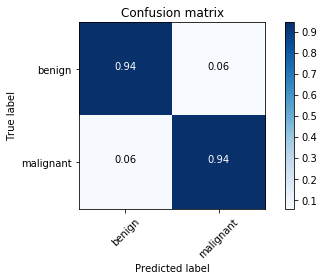

In [109]:
# Make a confusion matrix
confusion = confusion_matrix(classes_test, predictions)
plot_confusion_matrix(confusion, ['benign', 'malignant'], normalize=True)

<b>The confusion matrix makes it easy to visualize the True/False Positive/Negative rates</b>

<h2>Final Validation</h2>
<b>Now that a good model has been generated, it will be tested on 10 stratified samples to generate ROC curves and AUC <b1>

/home/mc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


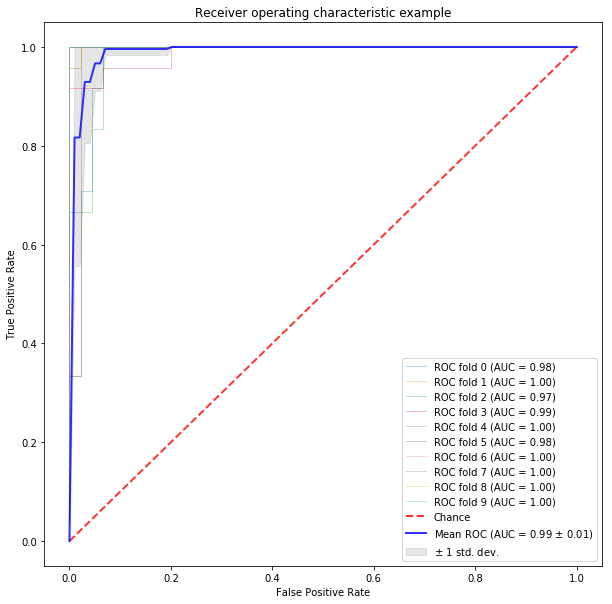

In [139]:
# Run classifier with cross-validation and plot ROC curves from Sklearn documentation

# Do StratifiedKFold sampling with 10 splits
cv = StratifiedKFold(n_splits=10)

# Use the parameters of the best estimator found using grid search
classifier = clone(best_classifier)

# Convert the features to matrix form to do series of classifications
X = features.as_matrix()
y = classes

# These will be the lists of mean True Positive Rates and Area Under Curves for plotting the ROC curves
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# For each sample is the stratified split, make predictions from the training data and plot the ROC curve and AUC
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

# Calculate the mean ROC curve and AUC from the stratified samples
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

# Set up figure parameters
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Breast Cancer Identification using a Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

<h1>Results</h1>
<b>Across 10 stratified samples, I achieved a mean AUC of 0.99 +/- 0.1, meaning the predictions made by the classifier are nearly completely correct.</b>
<b>One problem with this metric is that it assumes that the cost of Type I (false positives) and Type II (false negative) errors are equal. When it comes to identifying breast cancer, there is likely a high cost for Type II errors. From the confusion matrix, it can be seen that the rate of prediciting False Positives is equal to that of False Negatives, so this model may be tuned further to optimize for a decreased False Negative Rate.</b>

<b>Helper Functions from scikit-learn</b>

In [120]:
# Function for printing confusion matrix from Sklearn Documentation

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()